# Introduction

Collaborative filtering is an approach to implement recommender system which exploits information about similarity between users or items without relying on any domain specific knowledge.

In this work, we implement a basic recommender system based on Nearest Neigbors, that is, a method to relate the users based on their cosine similarity. First, we verify the typical long-tail distribution of the ratings, then we compute the consine similarity table and we compare the results with the implementation of the unsupervised learning [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) provided by scikit-learn. The dataset used is a small partition recommended for development of the full MovieLens dataset. The dataset is available [here](https://grouplens.org/datasets/movielens/). We will use only the `movies.csv` and `ratings.csv` files.

# Loading and exploration

Let's load and explore the datasets.

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

df_movie = pd.read_csv("./datasets/movielens/movies.csv")
df_movie.shape

(9742, 3)

In [2]:
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_rating = pd.read_csv("./datasets/movielens/ratings.csv")
df_rating.shape

(100836, 4)

In [4]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df_rating.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
df_rating["userId"].nunique()

610

In [7]:
df_rating["movieId"].nunique()

9724

From this first analysis we can observe that:
* in the *movies* dataset there are 9742 instances
* in the *ratings* dataset there are 100836 ratings ranging from 0.5 to 5
* there are 610 distinct users
* 9724 movies has received a rating. Comparing this values with the number of total movies, we can note that 18 movies does not have any rating.

Let's merge the two dataset together.

In [8]:
df_movie.drop(["genres"], axis=1, inplace=True)
df_rating.drop(["timestamp"], axis=1, inplace=True)
df = pd.merge(df_movie, df_rating, on="movieId")
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [9]:
df["movieId"].nunique()

9724

In [10]:
df["title"].nunique()

9719

In the resulting dataset we dropped the *genres* and the *timestamp* columns since we will not use them. Another thing to notice is the number of unique *movieId* compared to the number of unique *title*. This suggests us that we cannot rely on the title to identify a movie. Moreover, the movies without a rating have been dropped.

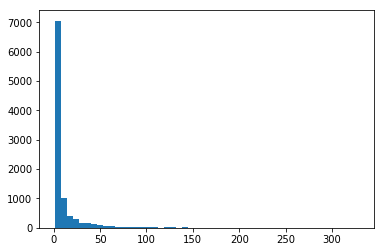

In [11]:
plt.hist(df.groupby("movieId")["rating"].count(), bins=50)
plt.show()

From the histogram above, we can see that a small number of movies is rated by a large number of users.

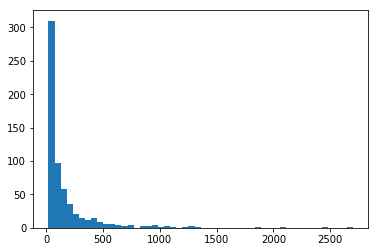

In [12]:
plt.hist(df.groupby("userId")["rating"].count(), bins=50)
plt.show()

At the same time, a small number of users is rating a large number of movies.

The two effects above verifies the typical long-tail distribution of the ratings with regards to the users and the items.

# Models implementation

Now, let's compute a pivot table with *userId* as rows and *movieId* as columns. The value $v_{i,j}$ of the cells will be the rating given by the user $i$ for the movie $j$. 

In [13]:
pivot_table = df.pivot_table(index="userId", columns="movieId", values="rating")
pivot_table.shape

(610, 9724)

In [14]:
pivot_table.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clearly, the resulting matrix is very sparse. Now, let's convert the NaN values to 0 and the values geater than 0 to 1. After that, we can compute the cosine similarity table, in which a value $v_{i,j}$ represents how similar the users $i$ and $j$ are.

In [15]:
pivot_table.fillna(0, inplace=True)
pivot_table = pivot_table.astype(bool).astype(int)
similarity_table = cosine_similarity(pivot_table)
similarity_table.shape

(610, 610)

In [16]:
similarity_table

array([[ 1.        ,  0.02438299,  0.0735905 , ...,  0.30973794,
         0.0971399 ,  0.12554505],
       [ 0.02438299,  1.        ,  0.        , ...,  0.0386502 ,
         0.03052813,  0.09263349],
       [ 0.0735905 ,  0.        ,  1.        , ...,  0.04999306,
         0.        ,  0.03106421],
       ..., 
       [ 0.30973794,  0.0386502 ,  0.04999306, ...,  1.        ,
         0.13116757,  0.28456777],
       [ 0.0971399 ,  0.03052813,  0.        , ...,  0.13116757,
         1.        ,  0.04556104],
       [ 0.12554505,  0.09263349,  0.03106421, ...,  0.28456777,
         0.04556104,  1.        ]])

If we want to retrieve the top 5 similar users to the user with *userId* 1, we take the indexes of the columns (or rows) with the highest values on the row (or column) with index 1. Clearly, we can ignore the first value since the user with maximum correlation is himself. Once we have the user ids, we could, for instance, take the top 5 rated movies of the most similar user and suggest them to the user 1.

In [17]:
pov_userid = 1
similarity_table[pov_userid].argsort()[-5:][::-1]

array([  1, 365, 377, 416, 460])

In [18]:
df[df["userId"] == 365].sort_values("rating", ascending=False).head(5)

,movieId,title,userId,rating
59603,4022,Cast Away (2000),365,5.0
69447,5989,Catch Me If You Can (2002),365,5.0
94554,95441,Ted (2012),365,5.0
99382,142422,The Night Before (2015),365,5.0
87877,61024,Pineapple Express (2008),365,5.0


We just created our basic recommender system (trivially generalizable). Now, let's compare the results with the implementation of NearestNeighbors provided by scikit-learn. 

In [19]:
knn = NearestNeighbors(metric="cosine")
knn.fit(pivot_table.values)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [20]:
knn.kneighbors(pivot_table.iloc[[pov_userid]])

(array([[  4.44089210e-16,   6.99833194e-01,   7.05169053e-01,
           7.27764445e-01,   7.49840409e-01]]),
 array([[  1, 365, 377, 416, 460]]))

As we can observe, the model NearestNeighbors returns the exact same top 5 neighbors of our implementation. We can use the results as show above.

# Outlook

We implemented the Nearest Neighbors approach in the context of the Collaborative Filtering. Another viable approach is the Matrix Factorization. It would be interesting to implement the latter and evaluate both methods with some suitable metrics, for example the Area Under ROC Curve (AUC).